In [1]:
import pandas as pd
import os.path as osp
import os
import re
from matplotlib import pyplot as plt
import statistics
import json
from scipy.stats import sem

get a table where the column names are the different KG settings

and the rows are the different approaches

and the values are metric

In [2]:
OUTPUT_DIR = '../data/output/ICLR_results'

In [3]:
approach_name_map = {'PoLo': 'PoLo',
                       'naive_updates': 'MARS, naive updates',
                       'p2h_updates': 'MARS, P2H updates'}

In [4]:
metric_dict = dict()

# iterate through subdirectories
for exp_name in os.listdir(OUTPUT_DIR):
    experiment = osp.join(OUTPUT_DIR, exp_name)
    if not osp.isdir(experiment):
        continue
    for approach in os.listdir(experiment):
        approach_dir = osp.join(experiment, approach)
        if not osp.isdir(approach_dir):
            continue
        approach_metrics_file = osp.join(approach_dir, 'experiment_metrics.tsv')
        approach_metrics = pd.read_csv(approach_metrics_file, sep='\t', index_col=0)
        for metric_name in approach_metrics.index:
            if metric_name not in metric_dict:
                metric_dict[metric_name] = dict()
            if exp_name not in metric_dict[metric_name]:
                metric_dict[metric_name][exp_name] = dict()

            metric_dict[metric_name][exp_name][approach_name_map[approach]] = approach_metrics.at[metric_name, ' metrics']
            metric_dict[metric_name][exp_name][approach_name_map[approach] + ' (pruned)'] = approach_metrics.at[metric_name, ' metrics (pruned)']

In [5]:
metric_tables = {metric_name: pd.DataFrame.from_dict(metric_dict[metric_name]) for metric_name in metric_dict.keys()}

In [6]:
column_order = ['MoA-net (with inverse edges)',
                                   'MoA-net-permuted (with inverse edges)',
                                   'MoA-net (no inverse edges)',
                       'MoA-net-10k (no inverse edges)',
                       'MoA-net-10k (with inverse edges)']

# reorder the experiment names
metric_tables = {metric_name: tab[column_order] for metric_name, tab in metric_tables.items()}

column_names = {name: name.replace(' ', '\n') for name in column_order}

# and rename them
metric_tables = {metric_name: tab.rename(columns=column_names) for metric_name, tab in metric_tables.items()}

now make functions to plot them

In [7]:
def get_avg_std(metric_table):
    # For every column remove the parentheses, and split by comma getting the first element
    table_values = metric_table.applymap(lambda x: x.split(",")[0].replace("(", ""))

    table_sd = metric_table.applymap(lambda x: x.split(",")[1].replace(")", ""))

    # to numeric
    table_values = table_values.apply(pd.to_numeric)
    table_sd = table_sd.apply(pd.to_numeric)

    new_order = [
    "PoLo",
    "MARS, naive updates",
    "MARS, P2H updates",
    "PoLo (pruned)",
    "MARS, naive updates (pruned)",
    "MARS, P2H updates (pruned)" 
    ]
    table_values = table_values.reindex(index=new_order)
    table_sd = table_sd.reindex(index=new_order)

    return table_values, table_sd

In [8]:
metric_tables.keys()

dict_keys(['Hits@1', 'Hits@3', 'Hits@5', 'Hits@10', 'Hits@20', 'MRR'])

In [9]:
def plot_metric(metric_name, table_values, table_sd, bottom_on=False):
    color_dict = {
    "PoLo": "#82a8a0",
    "PoLo (pruned)": "#eca86f",
    "MARS, P2H updates (pruned)": "#d73c24",
    "MARS, naive updates": "#1d6d8b",
    "MARS, naive updates (pruned)": "#e96f3d",
    "MARS, P2H updates": "#0d2b53",
}

    table_values.T.plot.bar(
        color=color_dict,
        yerr=table_sd.T,
        capsize=4,
        ecolor="black",
        error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
        # make bars thicker
        width=0.8,
    )

    # Move legend out
    plt.legend(loc="upper left")
    # Title legend
    #plt.title(
     #   f"{metric_name} of PoLo and MARS variants",
      #  pad=10,
       # fontsize=16,
    #)

    # Y label empty
    plt.ylabel(f"{metric_name}", labelpad=10, fontsize=20)
    # Y label 0-1
    plt.ylim(0, 1)
    
    # x labels rotation
    plt.xticks(rotation=0)

    # make bars thicker and reduce the space between ticks
    plt.tick_params(axis="x", width=0.5, length=2, pad=0.5)

    # X label
    if bottom_on:
        plt.xlabel("KG variant", labelpad=35, fontsize=14)
        plt.text(2, -0.32, '(and justification)', fontsize=10, color='black', ha='center', va='center')
        plt.text(0, -0.2, '(Initial experiments)', fontsize=7, color='black', ha='center', va='center')
        plt.text(1, -0.2, '(XSwap: Degree\nbias revealed)', fontsize=7, color='black', ha='center', va='center')
        plt.text(2, -0.2, '(Reasoning shortcut\nprohibited)', fontsize=7, color='black', ha='center', va='center')
        plt.text(3, -0.2, '(Performance restored\nvia KG trimming)', fontsize=7, color='black', ha='center', va='center')
        plt.text(4, -0.2, '(Reasoning shortcut\nallowed again)', fontsize=7, color='black', ha='center', va='center')
    else:
        plt.xticks([])

    # make the plot wider
    plt.gcf().set_size_inches(8, 6)

    # legend position down
    #plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2)


    plt.text(-0.5, 0.65, 'A', fontsize=12, color='black', ha='center', va='center')
    plt.text(0.5, 0.65, 'B', fontsize=12, color='black', ha='center', va='center')
    plt.text(1.5, 0.65, 'C', fontsize=12, color='black', ha='center', va='center')
    plt.text(2.5, 0.65, 'D', fontsize=12, color='black', ha='center', va='center')
    plt.text(3.5, 0.65, 'E', fontsize=12, color='black', ha='center', va='center')


    plt.show()

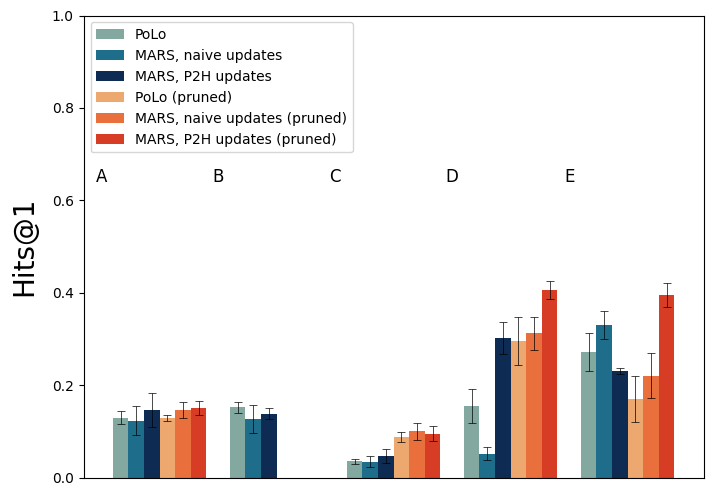

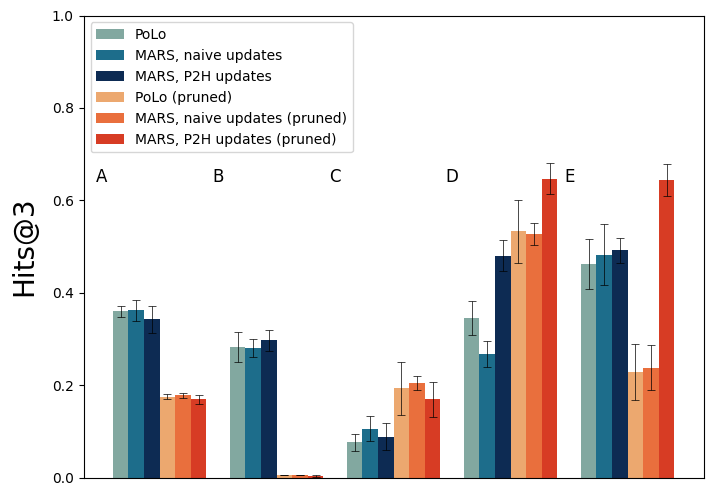

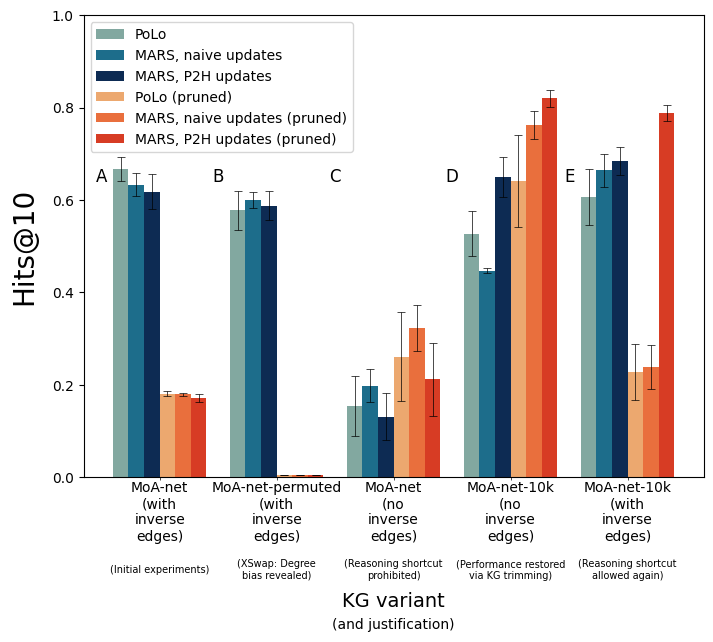

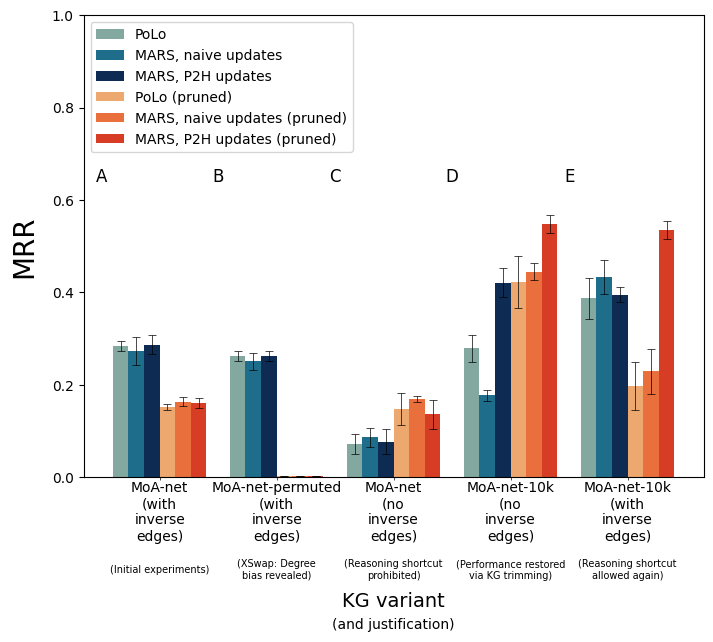

In [10]:
for metric_name, metric_table in metric_tables.items():
    if metric_name in set(['Hits@1', 'Hits@3', 'Hits@10', 'MRR']):
        bottom_on = False if metric_name in {'Hits@1', 'Hits@3'} else True
        table_values, table_sd = get_avg_std(metric_table)
        plot_metric(metric_name, table_values, table_sd, bottom_on=bottom_on)

## Supplementary Bar Charts

In [11]:
SUPPLEMENTARY_DIR = '../data/output/ICLR_supplementary'

In [12]:
metric_dict = dict()

# iterate through subdirectories
for experiment in [os.path.join(OUTPUT_DIR, 'MoA-net (no inverse edges)'),
                   os.path.join(OUTPUT_DIR, 'MoA-net-10k (no inverse edges)'),
                   os.path.join(SUPPLEMENTARY_DIR, 'MoA-net (no inverse edges; test=100)')]:
    exp_name = os.path.basename(experiment)
    for approach in os.listdir(experiment):
        approach_dir = osp.join(experiment, approach)
        if not osp.isdir(approach_dir):
            continue
        approach_metrics_file = osp.join(approach_dir, 'experiment_metrics.tsv')
        approach_metrics = pd.read_csv(approach_metrics_file, sep='\t', index_col=0)
        for metric_name in approach_metrics.index:
            if metric_name not in metric_dict:
                metric_dict[metric_name] = dict()
            if exp_name not in metric_dict[metric_name]:
                metric_dict[metric_name][exp_name] = dict()

            metric_dict[metric_name][exp_name][approach_name_map[approach]] = approach_metrics.at[metric_name, ' metrics']
            metric_dict[metric_name][exp_name][approach_name_map[approach] + ' (pruned)'] = approach_metrics.at[metric_name, ' metrics (pruned)']

In [13]:
metric_tables = {metric_name: pd.DataFrame.from_dict(metric_dict[metric_name]) for metric_name in metric_dict.keys()}

In [14]:
column_order = ['MoA-net (no inverse edges)',
                'MoA-net-10k (no inverse edges)',
                       'MoA-net (no inverse edges; test=100)']

# reorder the experiment names
metric_tables = {metric_name: tab[column_order] for metric_name, tab in metric_tables.items()}

column_names = {name: name.replace(' ', '\n') for name in column_order}

# and rename them
metric_tables = {metric_name: tab.rename(columns=column_names) for metric_name, tab in metric_tables.items()}

In [15]:
def plot_metric(metric_name, table_values, table_sd, bottom_on=False):
    color_dict = {
    "PoLo": "#82a8a0",
    "PoLo (pruned)": "#eca86f",
    "MARS, P2H updates (pruned)": "#d73c24",
    "MARS, naive updates": "#1d6d8b",
    "MARS, naive updates (pruned)": "#e96f3d",
    "MARS, P2H updates": "#0d2b53",
}

    table_values.T.plot.bar(
        color=color_dict,
        yerr=table_sd.T,
        capsize=4,
        ecolor="black",
        error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
        # make bars thicker
        width=0.8,
    )

    # Move legend out
    plt.legend(loc="upper left")
    # Title legend
    #plt.title(
     #   f"{metric_name} of PoLo and MARS variants",
      #  pad=10,
       # fontsize=16,
    #)

    # Y label empty
    plt.ylabel(f"{metric_name}", labelpad=10, fontsize=20)
    # Y label 0-1
    plt.ylim(0, 1)
    
    # x labels rotation
    plt.xticks(rotation=0)

    # make bars thicker and reduce the space between ticks
    plt.tick_params(axis="x", width=0.5, length=2, pad=0.5)

    # X label
    if bottom_on:
        plt.xlabel("KG variant", labelpad=30, fontsize=14)
        plt.text(1, -0.32, '(and justification)', fontsize=10, color='black', ha='center', va='center')
        plt.text(0, -0.2, '(Reasoning shortcut\nprohibited)', fontsize=7, color='black', ha='center', va='center')
        plt.text(1, -0.2, '(Performance restored\nvia KG trimming)', fontsize=7, color='black', ha='center', va='center')
        plt.text(2, -0.2, '(Ablation: MoA-net with\nsmaller test set)', fontsize=7, color='black', ha='center', va='center')

    else:
        plt.xticks([])

    # make the plot wider
    plt.gcf().set_size_inches(8, 6)

    plt.text(-0.5, 0.65, 'C', fontsize=12, color='black', ha='left', va='center')
    plt.text(0.5, 0.65, 'D', fontsize=12, color='black', ha='left', va='center')
    plt.text(1.5, 0.65, 'C (test=100)', fontsize=12, color='black', ha='left', va='center')

    # legend position down
    #plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2)

    plt.show()

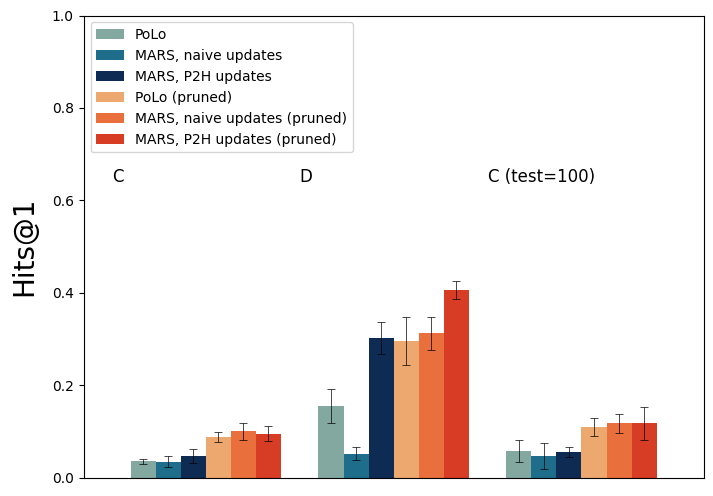

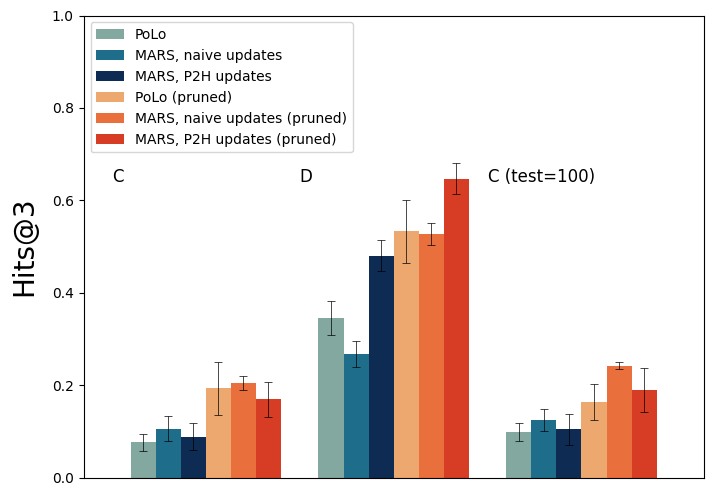

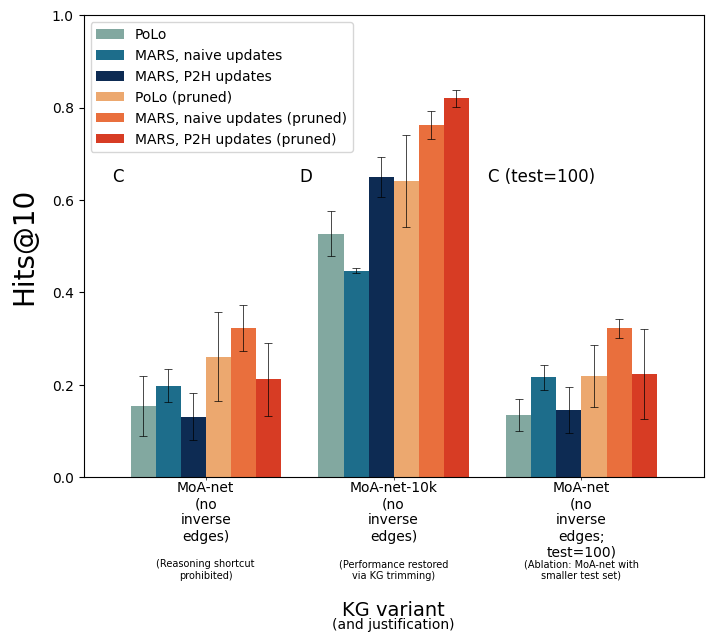

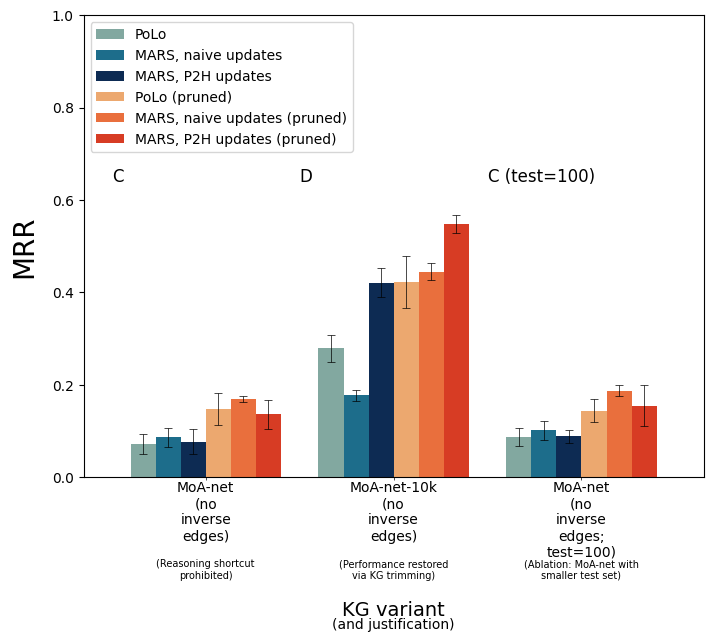

In [16]:
for metric_name, metric_table in metric_tables.items():
    if metric_name in set(['Hits@1', 'Hits@3', 'Hits@10', 'MRR']):
        bottom_on = False if metric_name in {'Hits@1', 'Hits@3'} else True
        table_values, table_sd = get_avg_std(metric_table)
        plot_metric(metric_name, table_values, table_sd, bottom_on=bottom_on)

In [17]:
metric_dict = dict()

# iterate through subdirectories
for experiment in [os.path.join(OUTPUT_DIR, 'MoA-net-10k (with inverse edges)'),
                   os.path.join(SUPPLEMENTARY_DIR, 'MoA-net-10k-permuted (with inverse edges)')]:
    exp_name = os.path.basename(experiment)
    for approach in os.listdir(experiment):
        if approach != 'p2h_updates':
            continue
        approach_dir = osp.join(experiment, approach)
        if not osp.isdir(approach_dir):
            continue
        approach_metrics_file = osp.join(approach_dir, 'experiment_metrics.tsv')
        approach_metrics = pd.read_csv(approach_metrics_file, sep='\t', index_col=0)
        for metric_name in approach_metrics.index:
            if metric_name not in metric_dict:
                metric_dict[metric_name] = dict()
            if exp_name not in metric_dict[metric_name]:
                metric_dict[metric_name][exp_name] = dict()

            metric_dict[metric_name][exp_name][approach_name_map[approach]] = approach_metrics.at[metric_name, ' metrics']
            metric_dict[metric_name][exp_name][approach_name_map[approach] + ' (pruned)'] = approach_metrics.at[metric_name, ' metrics (pruned)']

In [18]:
metric_tables = {metric_name: pd.DataFrame.from_dict(metric_dict[metric_name]) for metric_name in metric_dict.keys()}

In [19]:
column_order = ['MoA-net-10k (with inverse edges)',
                'MoA-net-10k-permuted (with inverse edges)']

# reorder the experiment names
metric_tables = {metric_name: tab[column_order] for metric_name, tab in metric_tables.items()}

column_names = {name: name.replace(' ', '\n') for name in column_order}

# and rename them
metric_tables = {metric_name: tab.rename(columns=column_names) for metric_name, tab in metric_tables.items()}

In [20]:
def get_avg_std(metric_table):
    # For every column remove the parentheses, and split by comma getting the first element
    table_values = metric_table.applymap(lambda x: x.split(",")[0].replace("(", ""))

    table_sd = metric_table.applymap(lambda x: x.split(",")[1].replace(")", ""))

    # to numeric
    table_values = table_values.apply(pd.to_numeric)
    table_sd = table_sd.apply(pd.to_numeric)

    new_order = [
    "MARS, P2H updates",
    "MARS, P2H updates (pruned)" 
    ]
    table_values = table_values.reindex(index=new_order)
    table_sd = table_sd.reindex(index=new_order)

    return table_values, table_sd

In [21]:
def plot_metric(metric_name, table_values, table_sd, bottom_on=False):
    color_dict = {
    "MARS, P2H updates (pruned)": "#d73c24",
    "MARS, P2H updates": "#0d2b53",
}

    table_values.T.plot.bar(
        color=color_dict,
        yerr=table_sd.T,
        capsize=4,
        ecolor="black",
        error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
        # make bars thicker
        width=0.8,
    )

    # Move legend out
    plt.legend(loc="upper left", fontsize=8)
    # Title legend
    #plt.title(
     #   f"{metric_name} of PoLo and MARS variants",
      #  pad=10,
       # fontsize=16,
    #)

    # Y label empty
    plt.ylabel(f"{metric_name}", labelpad=10, fontsize=12)
    # Y label 0-1
    plt.ylim(0, 1)
    
    # x labels rotation
    plt.xticks(rotation=0)

    # make bars thicker and reduce the space between ticks
    plt.tick_params(axis="x", width=0.5, length=2, pad=0.5)

    # X label
    if bottom_on:
        plt.xlabel("KG variant", labelpad=30, fontsize=14)
        plt.text(0.5, -0.6, '(and justification)', fontsize=8, color='black', ha='center', va='center')
        plt.text(0, -0.35, '(Reasoning shortcut\nallowed again)', fontsize=7, color='black', ha='center', va='center')
        plt.text(1, -0.35, '(XSwap: No evidence\nof degree bias)', fontsize=7, color='black', ha='center', va='center')

    else:
        plt.xticks([])

    # make the plot wider
    plt.gcf().set_size_inches(4, 3)

    plt.text(-0.5, 0.65, 'E', fontsize=12, color='black', ha='left', va='center')
    plt.text(0.5, 0.65, 'E (permuted)', fontsize=12, color='black', ha='left', va='center')

    # legend position down
    #plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2)

    plt.show()

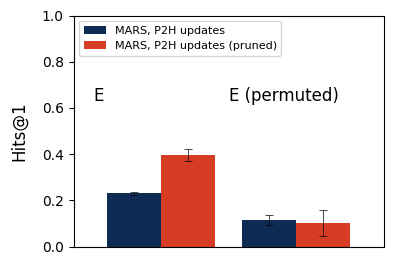

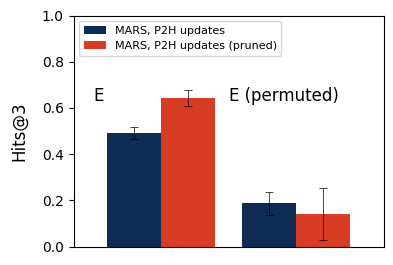

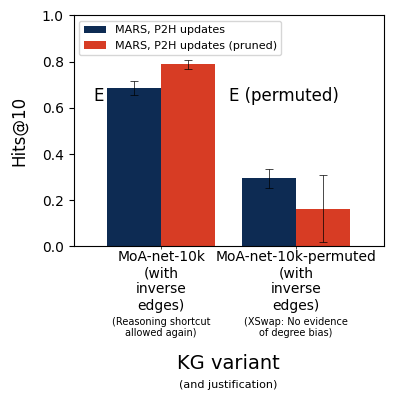

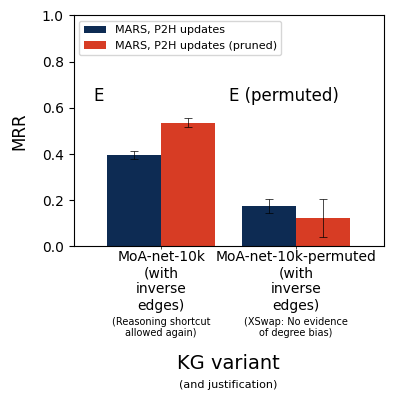

In [22]:
for metric_name, metric_table in metric_tables.items():
    if metric_name in set(['Hits@1', 'Hits@3', 'Hits@10', 'MRR']):
        bottom_on = False if metric_name in {'Hits@1', 'Hits@3'} else True
        table_values, table_sd = get_avg_std(metric_table)
        plot_metric(metric_name, table_values, table_sd, bottom_on=bottom_on)

## Confidence Plotting

These next functions are to plot the confidences by the metapaths to understand which metapaths were deemed most important.

In [23]:
# read in json file from MAPPING_DIR
with open('../data/kg/splits/MoA-net/MARS/vocab/meta_mapping.json') as fl:
    node_mapping = json.load(fl)

In [24]:
node_mapping['G'] = 'Protein'

In [25]:
def get_rel_mapping(item_to_map):
    """Gets the relation mapping for the KG."""
    capital_groups = re.findall('[A-Z]+', item_to_map)
    predicate = re.findall('[a-z]+', item_to_map)
    predicate = node_mapping[predicate[0]]
    capital_groups = [node_mapping[i] for i in capital_groups]
    mapped_item = f"{predicate}({capital_groups[0]}, {capital_groups[1]})"
    if "_" in item_to_map:
        mapped_item += "*"
    return mapped_item

In [26]:
def plot_confidences(experiment_dir):
    """Plots the average confidences across runs for an experiment"""
    exp_confs = []
    output_path = osp.join(experiment_dir, "confidences.png")

    plt.figure(figsize=(8, 4))

    # all experimental runs
    runs = os.listdir(experiment_dir)

    for run in runs:
        if not osp.isdir(osp.join(experiment_dir, run)):
            continue
        # for each run in an experiment dir, get the paths dir
        fpath = osp.join(experiment_dir, f"{run}/confidences.txt")

        # Open the file for reading
        with open(fpath, "r") as file:
            confs = json.load(file)["CtBP"]
            confs_dict = dict()
            for mpath in confs:
                if "NO_OP" in mpath:
                    continue
                confs_dict[r' $\wedge$ '.join([get_rel_mapping(i) for i in mpath[2::]])] = float(
                    mpath[0]
                )
            exp_confs.append(confs_dict)

    avg_confs = dict()
    std_confs = dict()
    for key in exp_confs[0].keys():
        avg_confs[key] = statistics.mean(
            [exp_confs[n][key] for n in range(len(exp_confs))]
        )
        std_confs[key] = sem(
            [exp_confs[n][key] for n in range(len(exp_confs))]
        )

    avg_confs = dict(sorted(avg_confs.items(), key=lambda item: item[1], reverse=True))
    std_confs = dict(sorted(std_confs.items(), key=lambda item: item[1], reverse=True))

    # Extract keys and values from the dictionary
    keys = list(avg_confs.keys())
    values = list(avg_confs.values())
    stdevs = list(std_confs.values())

    # Create a bar plot with keys on the y-axis and values on the x-axis
    plt.barh(keys, values, height=0.5,
             xerr=stdevs, ecolor="black", error_kw=dict(lw=0.5, capsize=3, capthick=0.5), color="#0d2b53")

    # Set labels for the axes
    plt.xlabel("Confidence", fontsize=16, labelpad=10, fontweight="bold")
    plt.ylabel("Metapath-based\nrule body", fontsize=16, labelpad=10, fontweight="bold")

    # increase the font of the tick labels
    plt.tick_params(axis='both', labelsize=12)

    # Set a title for the plot
    plt.title("Confidences per metapath-based rule", fontsize=20)

    print(output_path)

    plt.savefig(output_path, dpi=300, bbox_inches="tight")

../data/output/ICLR_results/MoA-net (with inverse edges)/p2h_updates/confidences.png
../data/output/ICLR_results/MoA-net (with inverse edges)/naive_updates/confidences.png
../data/output/ICLR_results/MoA-net (with inverse edges)/PoLo/confidences.png
../data/output/ICLR_results/MoA-net-10k (no inverse edges)/p2h_updates/confidences.png
../data/output/ICLR_results/MoA-net-10k (no inverse edges)/naive_updates/confidences.png
../data/output/ICLR_results/MoA-net-10k (no inverse edges)/PoLo/confidences.png
../data/output/ICLR_results/MoA-net-10k (with inverse edges)/p2h_updates/confidences.png
../data/output/ICLR_results/MoA-net-10k (with inverse edges)/naive_updates/confidences.png
../data/output/ICLR_results/MoA-net-10k (with inverse edges)/PoLo/confidences.png
../data/output/ICLR_results/MoA-net (no inverse edges)/p2h_updates/confidences.png
../data/output/ICLR_results/MoA-net (no inverse edges)/naive_updates/confidences.png
../data/output/ICLR_results/MoA-net (no inverse edges)/PoLo/conf

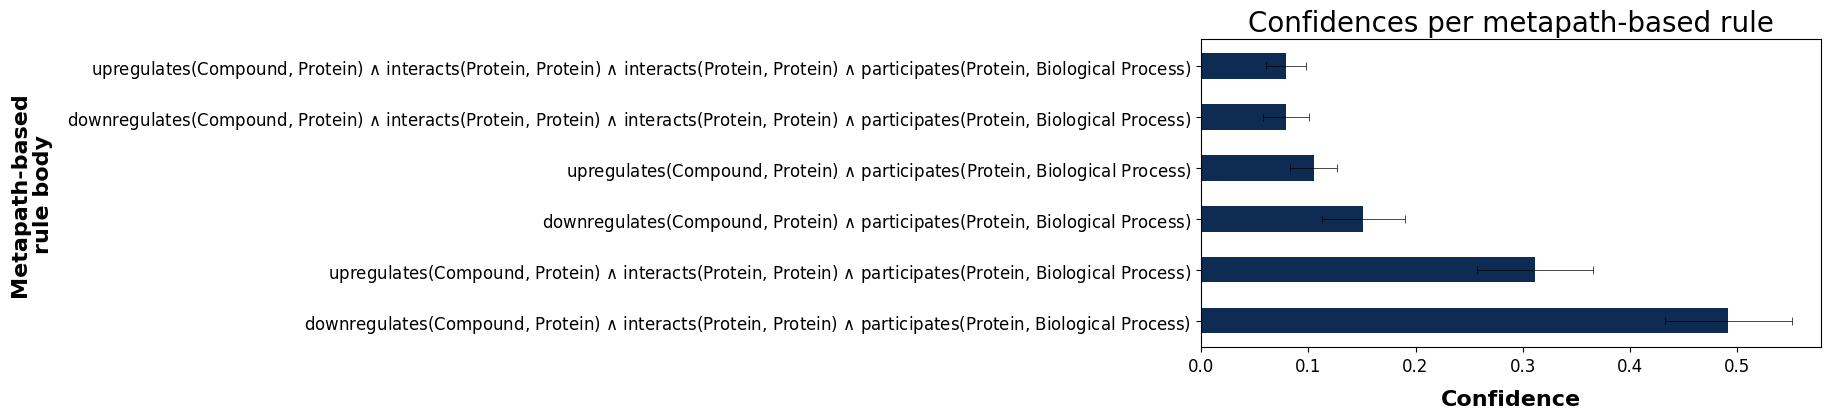

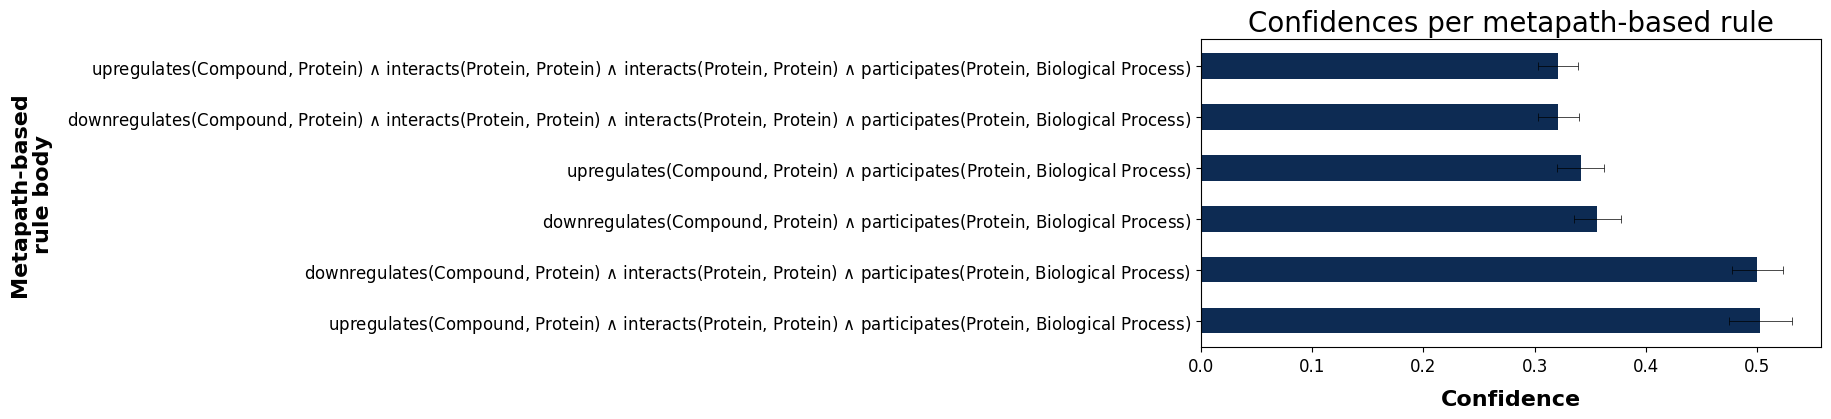

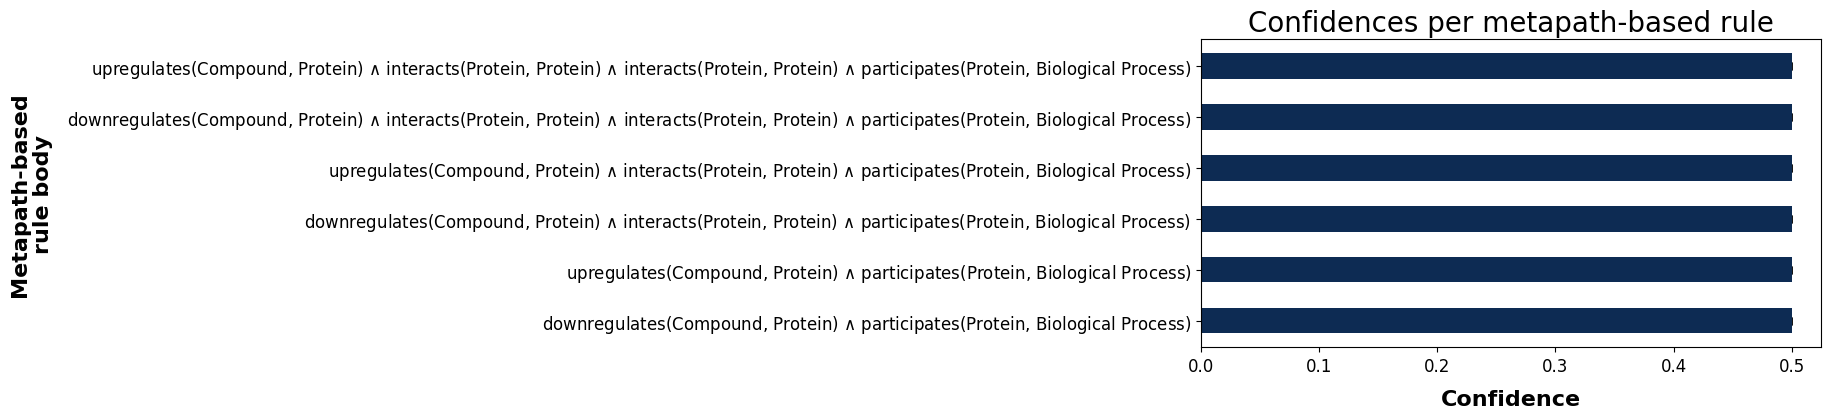

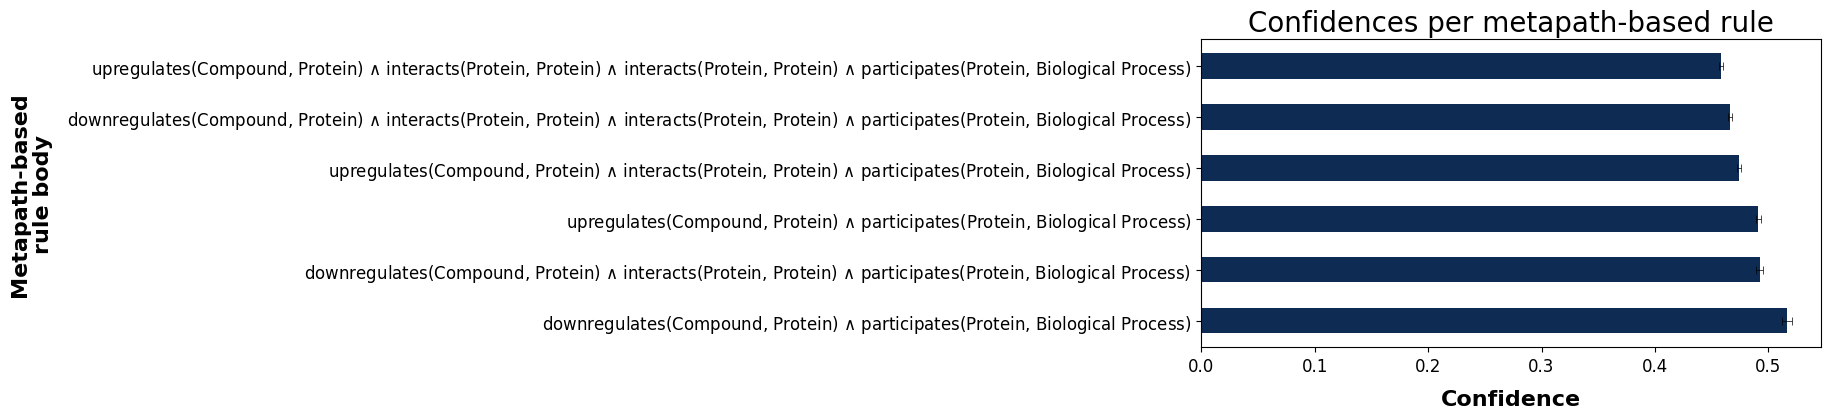

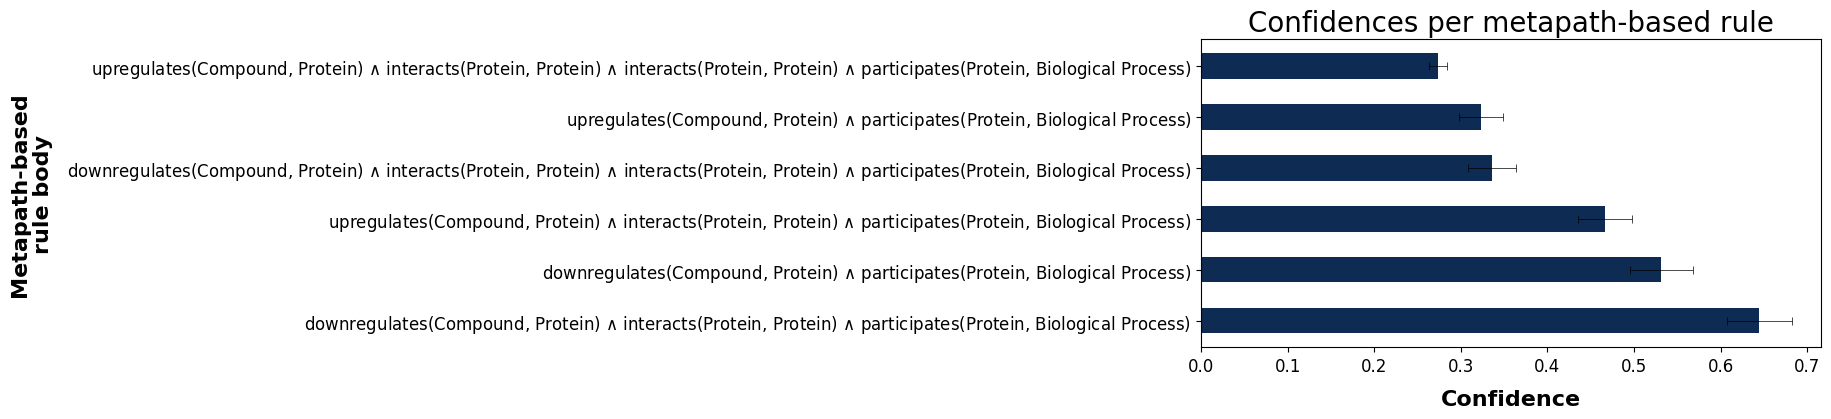

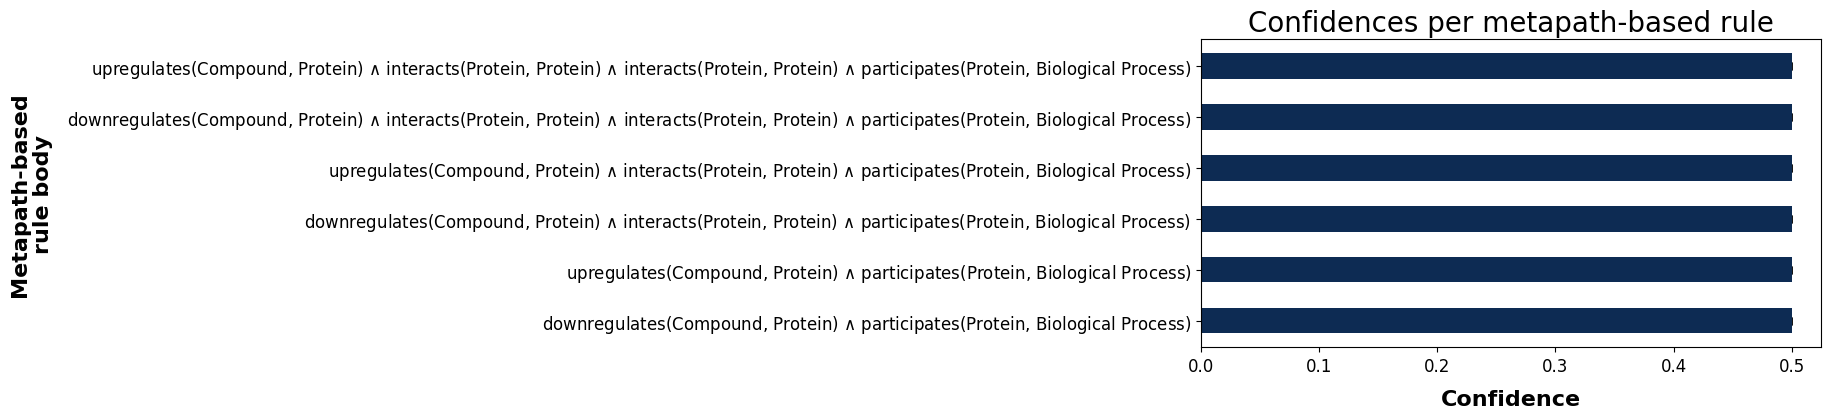

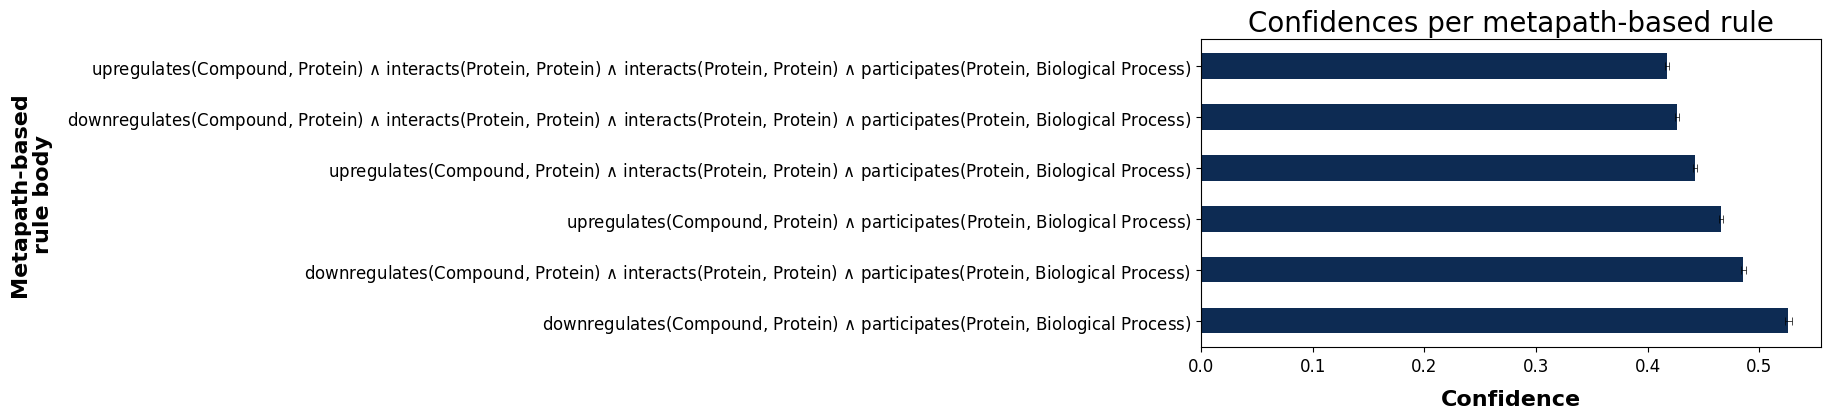

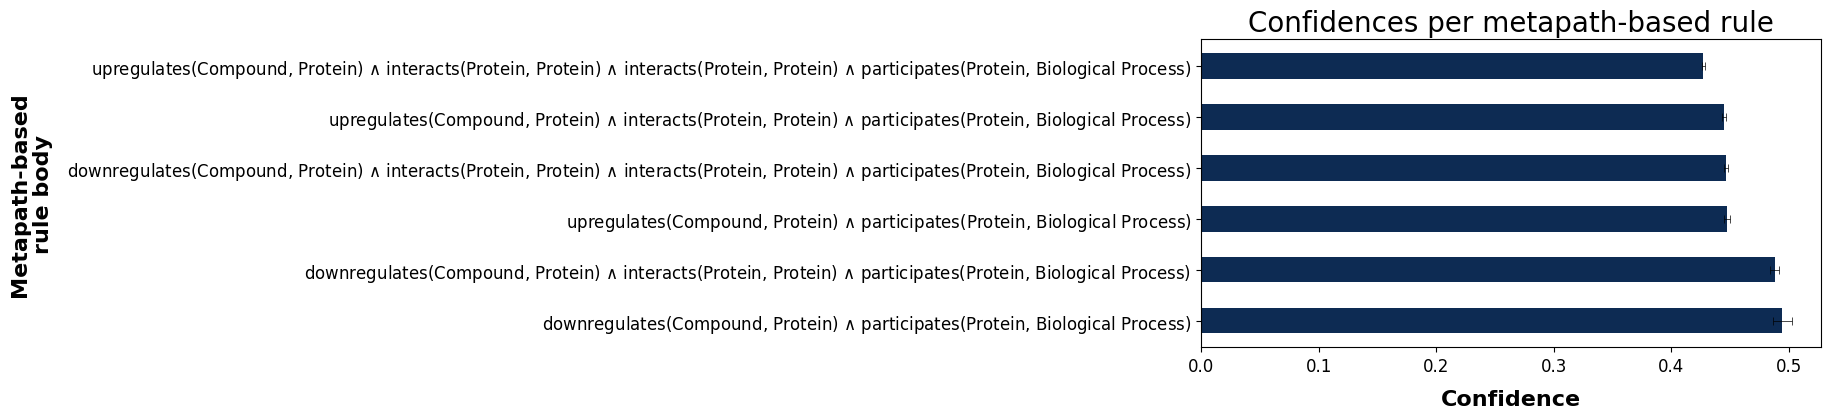

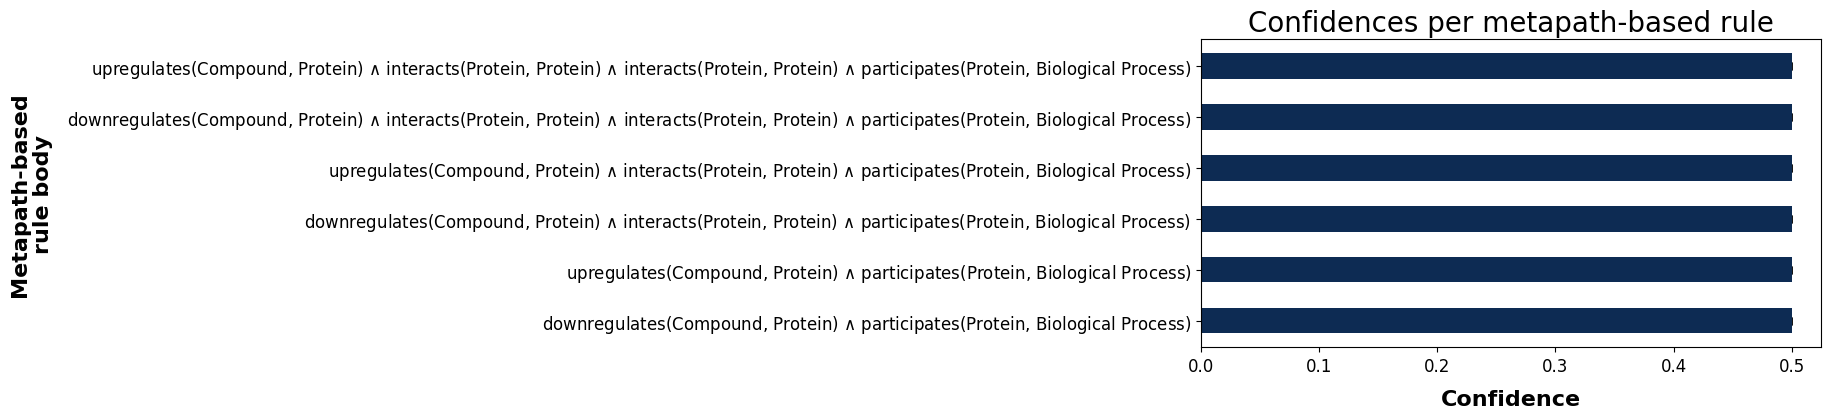

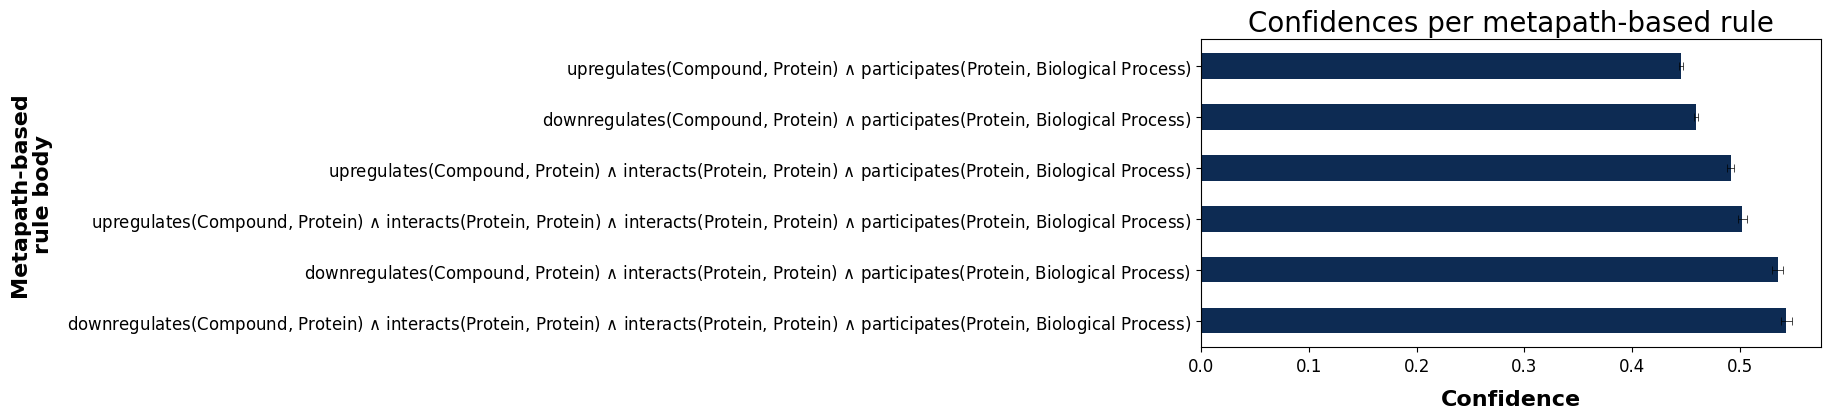

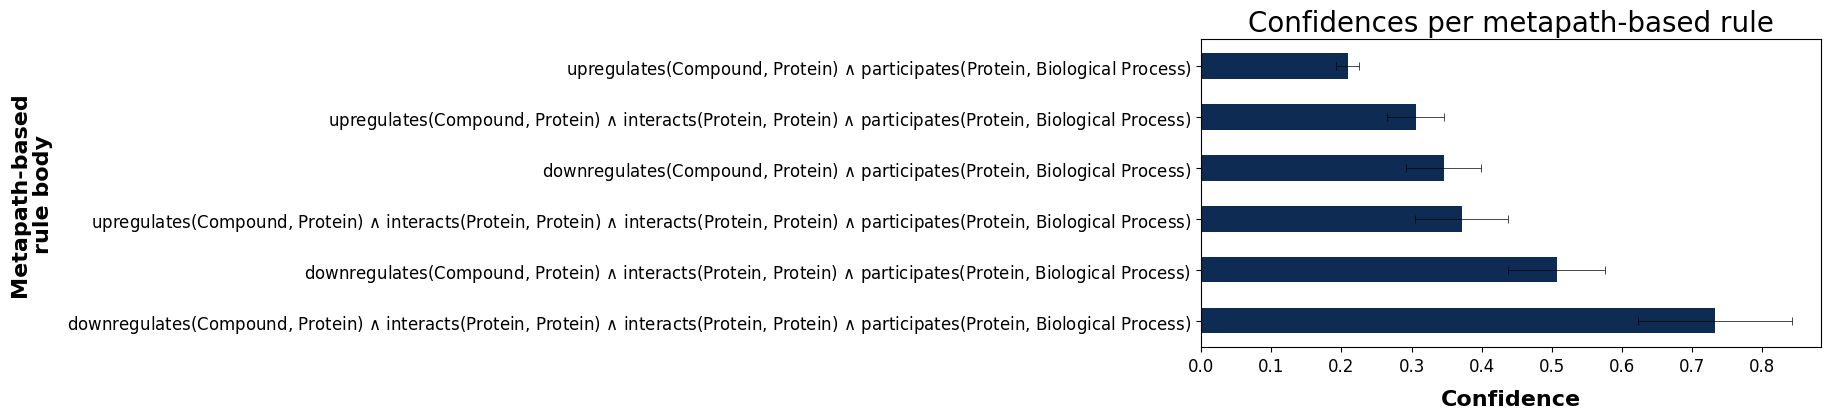

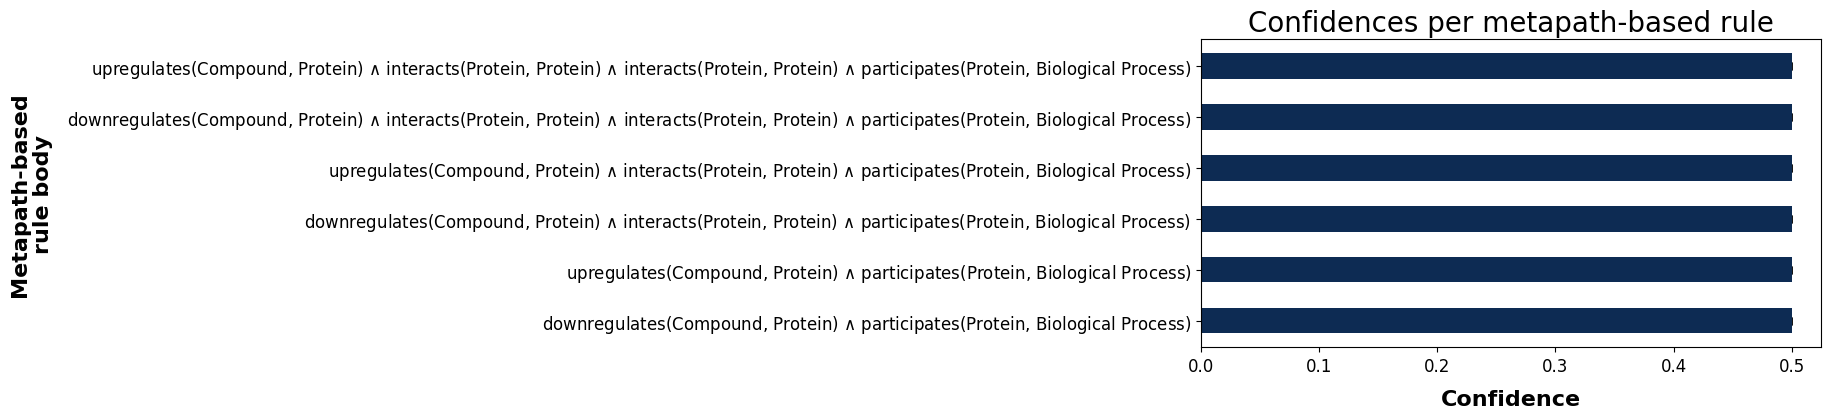

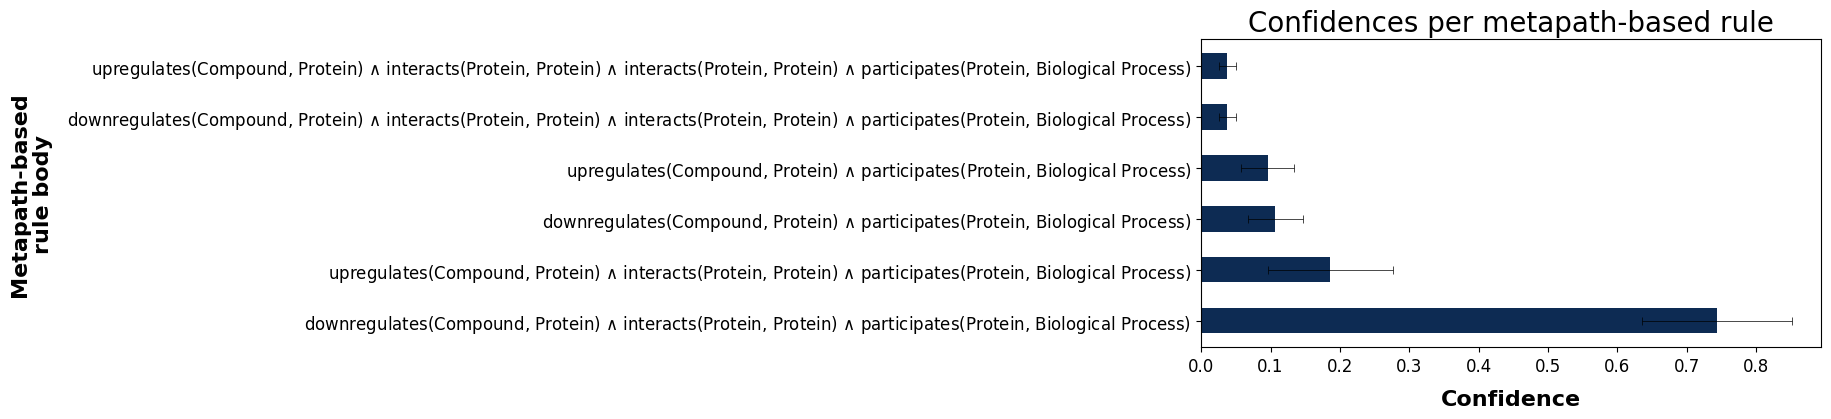

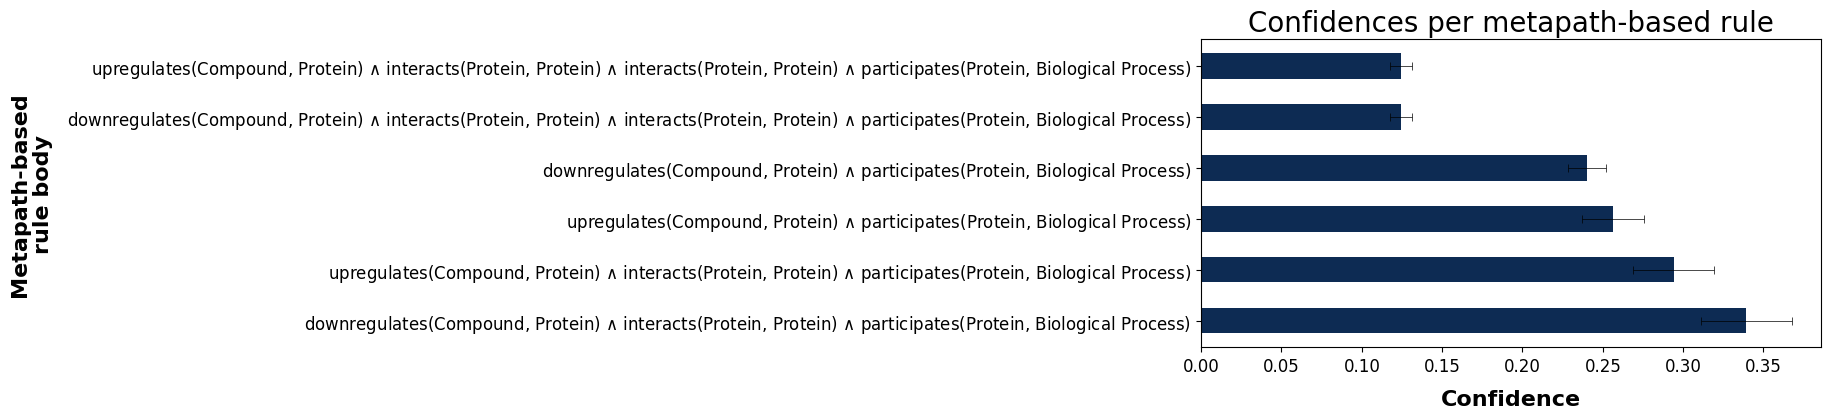

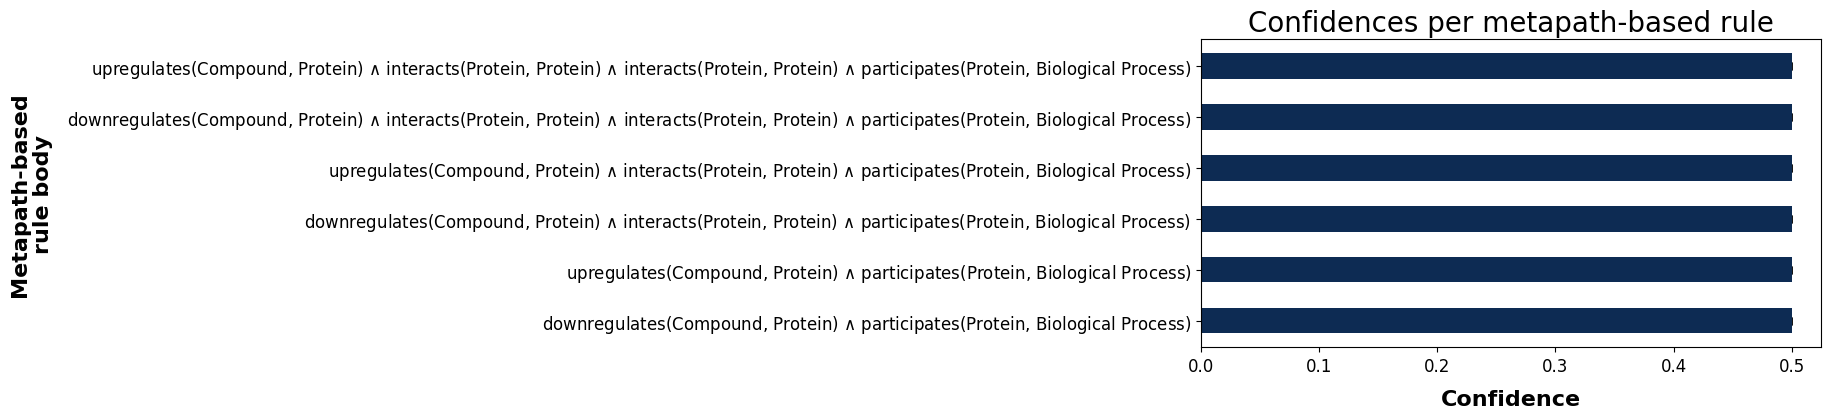

In [27]:
for subdir in os.listdir(OUTPUT_DIR):
    kg_dir = osp.join(OUTPUT_DIR, subdir)
    if osp.isdir(kg_dir):
        for subsubdir in os.listdir(kg_dir):
            experiment_dir = osp.join(kg_dir, subsubdir)
            if osp.isdir(experiment_dir):
                plot_confidences(experiment_dir)